# Multi-Model Comparison for SCADA Anomaly Detection
## SWaT Dataset - Comprehensive Algorithm Evaluation

This notebook compares multiple machine learning algorithms for anomaly detection in SCADA systems:

**Supervised Methods:**
1. Random Forest Classifier

**Unsupervised Methods:**
2. Isolation Forest
3. One-Class SVM
4. Autoencoder (Neural Network)
5. Local Outlier Factor (LOF)

**Objectives:**
- Compare detection performance across algorithms
- Analyze training time and inference speed
- Evaluate suitability for real-time SCADA deployment
- Provide recommendations based on empirical results

---

## Step 1: Setup and Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn models
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# TensorFlow/Keras for Autoencoder
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Model, Sequential
    from tensorflow.keras.layers import Input, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TF_AVAILABLE = True
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow not available - Autoencoder will be skipped")

print("All imports successful!")

TensorFlow version: 2.19.0
All imports successful!


## Step 2: Configuration

In [3]:
# =============================================================
# CONFIGURATION - UPDATE THESE PATHS!
# =============================================================

# Data paths
NORMAL_DATA_PATH = '/content/drive/MyDrive/SWaT_2015/Physical/SWaT_Normal.csv'      # Normal operation data (for training unsupervised)
ATTACK_DATA_PATH = '/content/drive/MyDrive/SWaT_2015/Physical/SWaT_Attack.csv'      # Attack data (for testing)

# Alternative: Single file with both normal and attack
# DATA_PATH = './SWaT_Dataset_Attack_v0.csv'

# Parameters
RANDOM_STATE = 42
TEST_SIZE = 0.2
CONTAMINATION = 0.12  # ~12% attacks in SWaT attack dataset

# Sampling (set to None to use all data, or a number to sample)
# Useful for faster experimentation
SAMPLE_SIZE = None  # e.g., 50000 for faster testing

print("Configuration loaded!")

Configuration loaded!


## Step 3: Load and Preprocess Data

In [4]:
def load_swat_data(file_path, header_row=1):
    """
    Load SWaT dataset with proper preprocessing.
    """
    print(f"Loading: {file_path}")

    # Load with correct header
    df = pd.read_csv(file_path, header=header_row)

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

    return df

# Try loading separate files first, fall back to single file
try:
    # Option 1: Separate normal and attack files
    normal_df = load_swat_data(NORMAL_DATA_PATH)
    attack_df = load_swat_data(ATTACK_DATA_PATH)

    # Combine for analysis
    data = attack_df.copy()  # Use attack data for evaluation
    USE_SEPARATE_FILES = True
    print("\n✅ Loaded separate normal and attack files")

except FileNotFoundError:
    # Option 2: Single combined file
    print("Separate files not found, trying combined file...")
    data = load_swat_data('./SWaT_Dataset_Attack_v0.csv', header_row=0)
    USE_SEPARATE_FILES = False
    print("\n✅ Loaded combined file")

Loading: /content/drive/MyDrive/SWaT_2015/Physical/SWaT_Normal.csv
  Shape: 495,000 rows × 53 columns
Loading: /content/drive/MyDrive/SWaT_2015/Physical/SWaT_Attack.csv
  Shape: 449,919 rows × 53 columns

✅ Loaded separate normal and attack files


In [5]:
# Preview data
print("Data preview:")
display(data.head())

print("\nColumn names:")
print(data.columns.tolist())

Data preview:


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal



Column names:
['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Normal/Attack']


In [6]:
# Find and process label column
label_col = None
for col in ['Normal/Attack', 'label', 'Label', 'Attack']:
    if col in data.columns:
        label_col = col
        break

if label_col:
    print(f"Label column: '{label_col}'")
    print(f"\nOriginal distribution:")
    print(data[label_col].value_counts())

    # Fix typos and convert to binary
    data[label_col] = data[label_col].replace({'A ttack': 'Attack'})
    data['label_binary'] = data[label_col].map({'Normal': 0, 'Attack': 1})

    # Handle any unmapped values
    if data['label_binary'].isna().sum() > 0:
        print(f"\n⚠️ Unmapped values found, filling with 1 (Attack)")
        data['label_binary'] = data['label_binary'].fillna(1).astype(int)

    print(f"\nBinary distribution:")
    print(f"  Normal (0): {(data['label_binary'] == 0).sum():,}")
    print(f"  Attack (1): {(data['label_binary'] == 1).sum():,}")
else:
    raise ValueError("No label column found!")

Label column: 'Normal/Attack'

Original distribution:
Normal/Attack
Normal     395298
Attack      54584
A ttack        37
Name: count, dtype: int64

Binary distribution:
  Normal (0): 395,298
  Attack (1): 54,621


In [7]:
# Select feature columns
exclude_cols = ['Timestamp', 'timestamp', 'Normal/Attack', 'label', 'Label', 'label_binary']
feature_columns = [col for col in data.columns if col not in exclude_cols]
feature_columns = data[feature_columns].select_dtypes(include=[np.number]).columns.tolist()

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns[:10]}...")

Number of features: 51
Features: ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201']...


In [8]:
# Prepare feature matrix and labels
X = data[feature_columns].values
y = data['label_binary'].values

# Handle missing values
if np.isnan(X).sum() > 0:
    print(f"Filling {np.isnan(X).sum()} missing values with column means")
    col_means = np.nanmean(X, axis=0)
    nan_indices = np.where(np.isnan(X))
    X[nan_indices] = np.take(col_means, nan_indices[1])

# Sample data if specified (for faster experimentation)
if SAMPLE_SIZE and SAMPLE_SIZE < len(X):
    print(f"\nSampling {SAMPLE_SIZE:,} rows from {len(X):,}...")
    indices = np.random.RandomState(RANDOM_STATE).choice(len(X), SAMPLE_SIZE, replace=False)
    X = X[indices]
    y = y[indices]

print(f"\nFinal dataset shape: {X.shape}")
print(f"  Normal: {(y == 0).sum():,} ({(y == 0).mean()*100:.1f}%)")
print(f"  Attack: {(y == 1).sum():,} ({(y == 1).mean()*100:.1f}%)")


Final dataset shape: (449919, 51)
  Normal: 395,298 (87.9%)
  Attack: 54,621 (12.1%)


## Step 4: Train/Test Split and Scaling

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"  Normal: {(y_train == 0).sum():,} | Attack: {(y_train == 1).sum():,}")
print(f"\nTest set: {X_test.shape[0]:,} samples")
print(f"  Normal: {(y_test == 0).sum():,} | Attack: {(y_test == 1).sum():,}")

Training set: 359,935 samples
  Normal: 316,238 | Attack: 43,697

Test set: 89,984 samples
  Normal: 79,060 | Attack: 10,924


In [10]:
# For unsupervised methods: train only on normal data
X_train_normal = X_train[y_train == 0]
print(f"Normal-only training set: {X_train_normal.shape[0]:,} samples")

Normal-only training set: 316,238 samples


In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_normal_scaled = scaler.transform(X_train_normal)

# MinMax scaler for Autoencoder (values between 0 and 1)
minmax_scaler = MinMaxScaler()
X_train_mm = minmax_scaler.fit_transform(X_train)
X_test_mm = minmax_scaler.transform(X_test)
X_train_normal_mm = minmax_scaler.transform(X_train_normal)

print("✅ Data scaled")

✅ Data scaled


## Step 5: Define Results Storage

In [14]:
# Store results for comparison
results = {
    'Model': [],
    'Type': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC-ROC': [],
    'Training Time (s)': [],
    'Inference Time (s)': [],
    'Predictions/sec': []
}

# Store predictions for visualization
all_predictions = {}
all_scores = {}

def evaluate_model(name, model_type, y_true, y_pred, y_scores, train_time, pred_time):
    """
    Evaluate model and store results.
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_scores)
    except:
        auc = 0.0

    # Store results
    results['Model'].append(name)
    results['Type'].append(model_type)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)
    results['AUC-ROC'].append(auc)
    results['Training Time (s)'].append(train_time)
    results['Inference Time (s)'].append(pred_time)
    results['Predictions/sec'].append(len(y_true) / pred_time if pred_time > 0 else 0)

    # Store predictions
    all_predictions[name] = y_pred
    all_scores[name] = y_scores

    # Print summary
    print(f"\n{'='*50}")
    print(f"{name} Results")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print(f"Training:  {train_time:.2f}s")
    print(f"Inference: {pred_time:.2f}s ({len(y_true)/pred_time:,.0f} pred/sec)")

    return accuracy, precision, recall, f1, auc

---
## Model 1: Random Forest (Supervised)

**Type:** Supervised Classification  
**Training Data:** Labeled normal + attack samples  
**Strengths:** High accuracy, interpretable, handles non-linear relationships  
**Weaknesses:** Requires labeled data, can't detect novel attacks

In [15]:
print("="*60)
print("MODEL 1: RANDOM FOREST (Supervised)")
print("="*60)

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train
print("Training Random Forest...")
start_time = datetime.now()
rf_model.fit(X_train_scaled, y_train)
rf_train_time = (datetime.now() - start_time).total_seconds()

# Predict
start_time = datetime.now()
rf_pred = rf_model.predict(X_test_scaled)
rf_scores = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_pred_time = (datetime.now() - start_time).total_seconds()

# Evaluate
evaluate_model('Random Forest', 'Supervised', y_test, rf_pred, rf_scores, rf_train_time, rf_pred_time)

MODEL 1: RANDOM FOREST (Supervised)
Training Random Forest...

Random Forest Results
Accuracy:  0.9997
Precision: 0.9982
Recall:    0.9994
F1-Score:  0.9988
AUC-ROC:   1.0000
Training:  98.10s
Inference: 1.33s (67,769 pred/sec)


(0.9996999466571835,
 0.9981713449757703,
 0.9993592090809227,
 0.9987649238369699,
 np.float64(0.9999988039156167))

---
## Model 2: Isolation Forest (Unsupervised)

**Type:** Unsupervised Anomaly Detection  
**Training Data:** Normal samples only (or mixed with contamination parameter)  
**Strengths:** No labels needed, detects novel anomalies, fast training  
**Weaknesses:** Higher false positive rate, no attack classification

In [16]:
print("\n" + "="*60)
print("MODEL 2: ISOLATION FOREST (Unsupervised)")
print("="*60)

# Initialize model
if_model = IsolationForest(
    n_estimators=100,
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train on normal data only
print("Training Isolation Forest on normal data...")
start_time = datetime.now()
if_model.fit(X_train_normal_scaled)
if_train_time = (datetime.now() - start_time).total_seconds()

# Predict
start_time = datetime.now()
if_pred_raw = if_model.predict(X_test_scaled)  # 1 = normal, -1 = anomaly
if_scores_raw = if_model.decision_function(X_test_scaled)
if_pred_time = (datetime.now() - start_time).total_seconds()

# Convert: IF returns 1 for normal, -1 for anomaly
# We want: 0 for normal, 1 for attack
if_pred = np.where(if_pred_raw == -1, 1, 0)
if_scores = -if_scores_raw  # Invert so higher = more anomalous

# Evaluate
evaluate_model('Isolation Forest', 'Unsupervised', y_test, if_pred, if_scores, if_train_time, if_pred_time)


MODEL 2: ISOLATION FOREST (Unsupervised)
Training Isolation Forest on normal data...

Isolation Forest Results
Accuracy:  0.8586
Precision: 0.4480
Recall:    0.7086
F1-Score:  0.5490
AUC-ROC:   0.8499
Training:  2.80s
Inference: 1.30s (69,342 pred/sec)


(0.8586415362731152,
 0.44802639194351196,
 0.7086232149395826,
 0.5489681582866464,
 np.float64(0.8499074754046609))

---
## Model 3: One-Class SVM (Unsupervised)

**Type:** Unsupervised Anomaly Detection  
**Training Data:** Normal samples only  
**Strengths:** Effective for high-dimensional data, kernel flexibility  
**Weaknesses:** Slow training on large datasets, sensitive to parameters

In [17]:
print("\n" + "="*60)
print("MODEL 3: ONE-CLASS SVM (Unsupervised)")
print("="*60)

# One-Class SVM is slow on large datasets, so we may need to subsample
max_train_samples = 50000  # Limit for reasonable training time

if len(X_train_normal_scaled) > max_train_samples:
    print(f"Subsampling to {max_train_samples:,} samples for OC-SVM (full data too slow)")
    indices = np.random.RandomState(RANDOM_STATE).choice(
        len(X_train_normal_scaled), max_train_samples, replace=False
    )
    X_train_ocsvm = X_train_normal_scaled[indices]
else:
    X_train_ocsvm = X_train_normal_scaled

# Initialize model
ocsvm_model = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=CONTAMINATION,  # Expected proportion of outliers
)

# Train
print(f"Training One-Class SVM on {len(X_train_ocsvm):,} samples...")
start_time = datetime.now()
ocsvm_model.fit(X_train_ocsvm)
ocsvm_train_time = (datetime.now() - start_time).total_seconds()

# Predict
start_time = datetime.now()
ocsvm_pred_raw = ocsvm_model.predict(X_test_scaled)  # 1 = normal, -1 = anomaly
ocsvm_scores_raw = ocsvm_model.decision_function(X_test_scaled)
ocsvm_pred_time = (datetime.now() - start_time).total_seconds()

# Convert predictions
ocsvm_pred = np.where(ocsvm_pred_raw == -1, 1, 0)
ocsvm_scores = -ocsvm_scores_raw

# Evaluate
evaluate_model('One-Class SVM', 'Unsupervised', y_test, ocsvm_pred, ocsvm_scores, ocsvm_train_time, ocsvm_pred_time)


MODEL 3: ONE-CLASS SVM (Unsupervised)
Subsampling to 50,000 samples for OC-SVM (full data too slow)
Training One-Class SVM on 50,000 samples...

One-Class SVM Results
Accuracy:  0.8790
Precision: 0.5010
Recall:    0.8562
F1-Score:  0.6321
AUC-ROC:   0.9142
Training:  60.83s
Inference: 106.46s (845 pred/sec)


(0.8790007112375533,
 0.5009641135511516,
 0.856188209447089,
 0.6320875853213489,
 np.float64(0.9141797552030944))

---
## Model 4: Local Outlier Factor (Unsupervised)

**Type:** Unsupervised Anomaly Detection  
**Training Data:** Normal samples only  
**Strengths:** Density-based, good for local anomalies  
**Weaknesses:** Memory intensive, slow inference on large datasets

In [18]:
print("\n" + "="*60)
print("MODEL 4: LOCAL OUTLIER FACTOR (Unsupervised)")
print("="*60)

# LOF for novelty detection
lof_model = LocalOutlierFactor(
    n_neighbors=20,
    contamination=CONTAMINATION,
    novelty=True,  # Enable predict on new data
    n_jobs=-1
)

# Subsample if needed (LOF can be slow)
max_train_samples_lof = 50000
if len(X_train_normal_scaled) > max_train_samples_lof:
    print(f"Subsampling to {max_train_samples_lof:,} samples for LOF")
    indices = np.random.RandomState(RANDOM_STATE).choice(
        len(X_train_normal_scaled), max_train_samples_lof, replace=False
    )
    X_train_lof = X_train_normal_scaled[indices]
else:
    X_train_lof = X_train_normal_scaled

# Train
print(f"Training LOF on {len(X_train_lof):,} samples...")
start_time = datetime.now()
lof_model.fit(X_train_lof)
lof_train_time = (datetime.now() - start_time).total_seconds()

# Predict
start_time = datetime.now()
lof_pred_raw = lof_model.predict(X_test_scaled)
lof_scores_raw = lof_model.decision_function(X_test_scaled)
lof_pred_time = (datetime.now() - start_time).total_seconds()

# Convert predictions
lof_pred = np.where(lof_pred_raw == -1, 1, 0)
lof_scores = -lof_scores_raw

# Evaluate
evaluate_model('Local Outlier Factor', 'Unsupervised', y_test, lof_pred, lof_scores, lof_train_time, lof_pred_time)


MODEL 4: LOCAL OUTLIER FACTOR (Unsupervised)
Subsampling to 50,000 samples for LOF
Training LOF on 50,000 samples...

Local Outlier Factor Results
Accuracy:  0.8866
Precision: 0.5181
Recall:    0.9410
F1-Score:  0.6682
AUC-ROC:   0.9691
Training:  22.53s
Inference: 86.23s (1,044 pred/sec)


(0.8865798364153628,
 0.5180947580645161,
 0.9409556938850238,
 0.6682486022623846,
 np.float64(0.9690929942755611))

---
## Model 5: Autoencoder (Deep Learning - Unsupervised)

**Type:** Unsupervised Anomaly Detection (Reconstruction-based)  
**Training Data:** Normal samples only  
**Strengths:** Learns complex patterns, flexible architecture  
**Weaknesses:** Requires tuning, longer training, less interpretable

In [19]:
if TF_AVAILABLE:
    print("\n" + "="*60)
    print("MODEL 5: AUTOENCODER (Deep Learning - Unsupervised)")
    print("="*60)

    # Define autoencoder architecture
    input_dim = X_train.shape[1]
    encoding_dim = 16  # Compressed representation

    # Build model
    autoencoder = Sequential([
        # Encoder
        Dense(32, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(encoding_dim, activation='relu'),
        # Decoder
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(input_dim, activation='sigmoid')  # Output same dimension as input
    ])

    autoencoder.compile(
        optimizer='adam',
        loss='mse'  # Reconstruction error
    )

    print(f"\nAutoencoder architecture:")
    print(f"  Input: {input_dim} → 32 → {encoding_dim} → 32 → {input_dim}")

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train on normal data only
    print(f"\nTraining Autoencoder on {len(X_train_normal_mm):,} normal samples...")
    start_time = datetime.now()

    history = autoencoder.fit(
        X_train_normal_mm, X_train_normal_mm,  # Input = Output (reconstruction)
        epochs=50,
        batch_size=256,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )

    ae_train_time = (datetime.now() - start_time).total_seconds()
    print(f"Training completed in {ae_train_time:.2f}s ({len(history.history['loss'])} epochs)")

    # Calculate reconstruction error on test set
    start_time = datetime.now()
    X_test_reconstructed = autoencoder.predict(X_test_mm, verbose=0)
    reconstruction_error = np.mean(np.square(X_test_mm - X_test_reconstructed), axis=1)
    ae_pred_time = (datetime.now() - start_time).total_seconds()

    # Determine threshold using percentile
    threshold = np.percentile(reconstruction_error, (1 - CONTAMINATION) * 100)
    print(f"Anomaly threshold (reconstruction error): {threshold:.6f}")

    # Classify based on reconstruction error
    ae_pred = (reconstruction_error > threshold).astype(int)
    ae_scores = reconstruction_error  # Higher error = more anomalous

    # Evaluate
    evaluate_model('Autoencoder', 'Unsupervised (DL)', y_test, ae_pred, ae_scores, ae_train_time, ae_pred_time)

else:
    print("\n⚠️ Skipping Autoencoder - TensorFlow not available")


MODEL 5: AUTOENCODER (Deep Learning - Unsupervised)

Autoencoder architecture:
  Input: 51 → 32 → 16 → 32 → 51

Training Autoencoder on 316,238 normal samples...
Training completed in 183.17s (50 epochs)
Anomaly threshold (reconstruction error): 0.005742

Autoencoder Results
Accuracy:  0.9483
Precision: 0.7905
Recall:    0.7814
F1-Score:  0.7859
AUC-ROC:   0.9385
Training:  183.17s
Inference: 3.85s (23,368 pred/sec)


---
## Step 6: Results Comparison

In [20]:
# Create results DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("COMPLETE MODEL COMPARISON RESULTS")
print("="*80)
display(results_df.round(4))


COMPLETE MODEL COMPARISON RESULTS


,Model,Type,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Training Time (s),Inference Time (s),Predictions/sec
0,Random Forest,Supervised,0.9997,0.9982,0.9994,0.9988,1.0000,98.0973,1.3278,67768.6299
1,Isolation Forest,Unsupervised,0.8586,0.4480,0.7086,0.5490,0.8499,2.8044,1.2977,69342.0504
2,One-Class SVM,Unsupervised,0.8790,0.5010,0.8562,0.6321,0.9142,60.8304,106.4552,845.2761
3,Local Outlier Factor,Unsupervised,0.8866,0.5181,0.9410,0.6682,0.9691,22.5320,86.2259,1043.5839
4,Autoencoder,Unsupervised (DL),0.9483,0.7905,0.7814,0.7859,0.9385,183.1726,3.8508,23367.6665


In [21]:
# Sort by F1-Score
print("\nModels Ranked by F1-Score:")
print(results_df.sort_values('F1-Score', ascending=False)[['Model', 'Type', 'F1-Score', 'Precision', 'Recall']].to_string(index=False))


Models Ranked by F1-Score:
               Model              Type  F1-Score  Precision   Recall
       Random Forest        Supervised  0.998765   0.998171 0.999359
         Autoencoder Unsupervised (DL)  0.785931   0.790517 0.781399
Local Outlier Factor      Unsupervised  0.668249   0.518095 0.940956
       One-Class SVM      Unsupervised  0.632088   0.500964 0.856188
    Isolation Forest      Unsupervised  0.548968   0.448026 0.708623


In [22]:
# Sort by Recall (important for security - don't miss attacks!)
print("\nModels Ranked by Recall (Attack Detection Rate):")
print(results_df.sort_values('Recall', ascending=False)[['Model', 'Type', 'Recall', 'Precision', 'F1-Score']].to_string(index=False))


Models Ranked by Recall (Attack Detection Rate):
               Model              Type   Recall  Precision  F1-Score
       Random Forest        Supervised 0.999359   0.998171  0.998765
Local Outlier Factor      Unsupervised 0.940956   0.518095  0.668249
       One-Class SVM      Unsupervised 0.856188   0.500964  0.632088
         Autoencoder Unsupervised (DL) 0.781399   0.790517  0.785931
    Isolation Forest      Unsupervised 0.708623   0.448026  0.548968


## Step 7: Visualizations

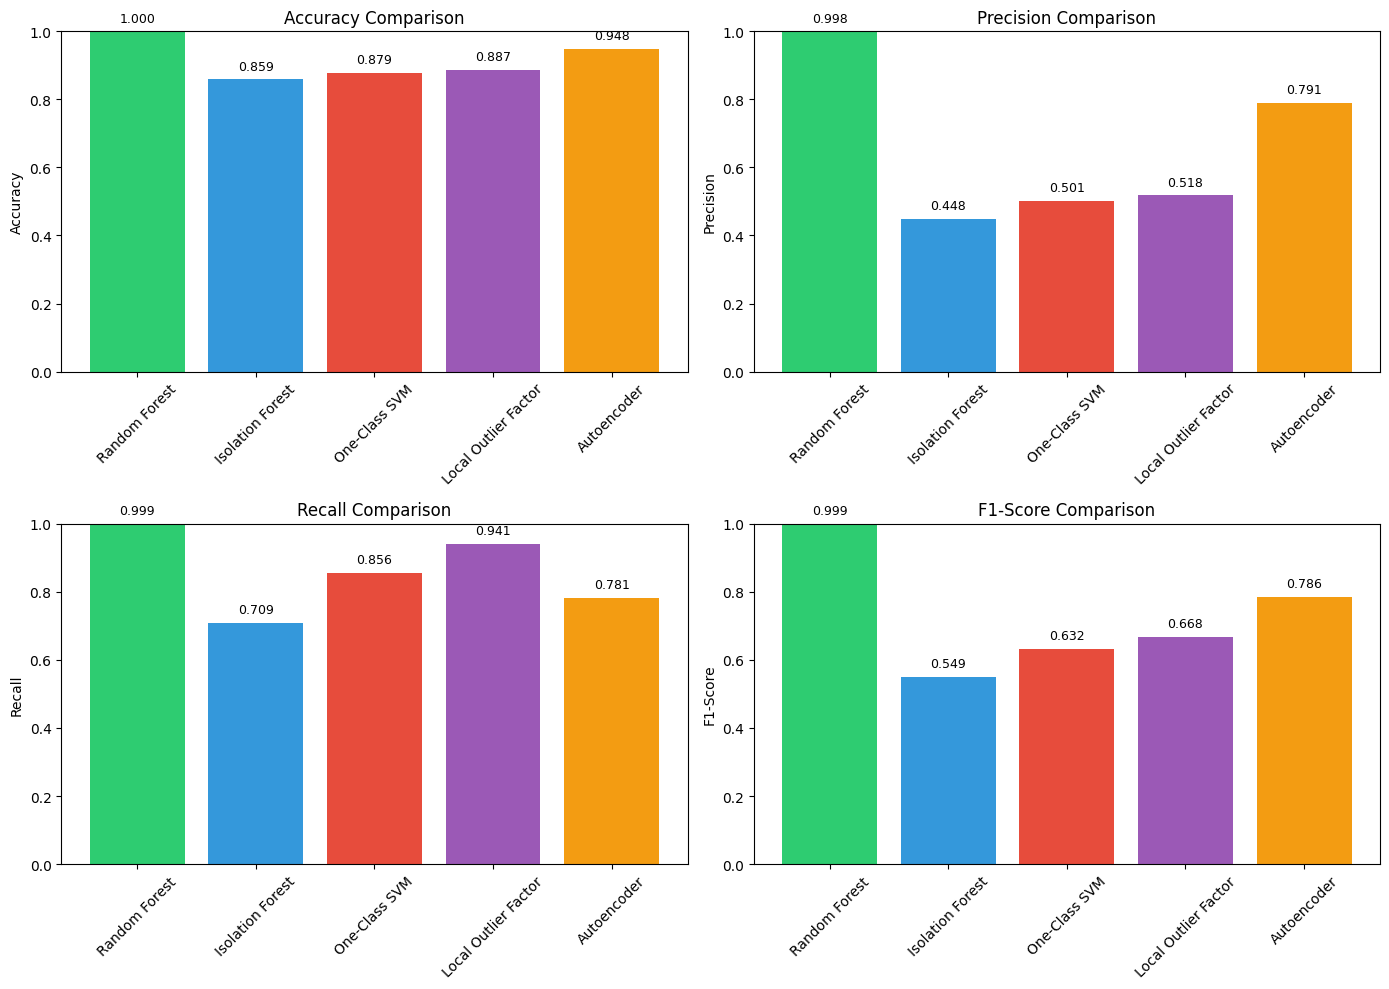

Saved: model_comparison_metrics.png


In [23]:
# Performance comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors[:len(results_df)])
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

    # Add value labels
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: model_comparison_metrics.png")

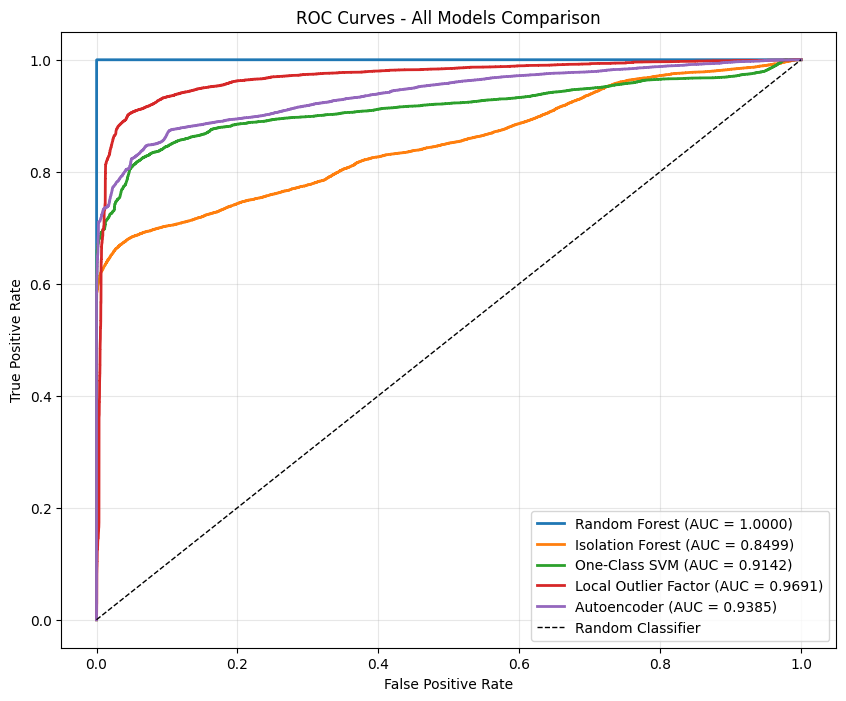

Saved: model_comparison_roc.png


In [24]:
# ROC Curves comparison
plt.figure(figsize=(10, 8))

for name, scores in all_scores.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('model_comparison_roc.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: model_comparison_roc.png")

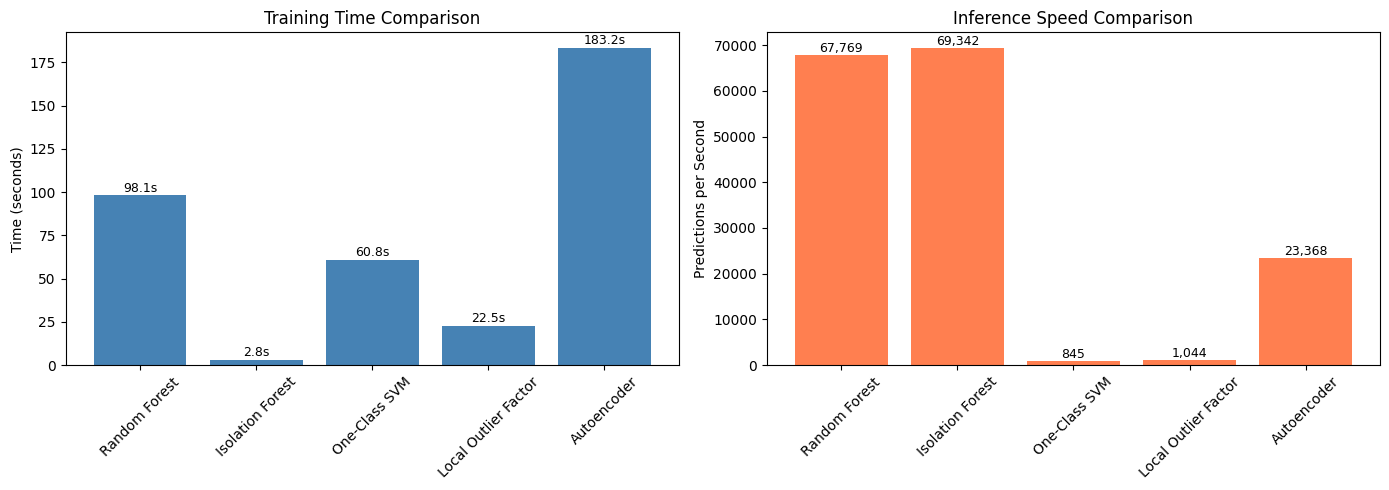

Saved: model_comparison_time.png


In [25]:
# Training and Inference Time comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training time
ax1 = axes[0]
bars1 = ax1.bar(results_df['Model'], results_df['Training Time (s)'], color='steelblue')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Training Time Comparison')
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, results_df['Training Time (s)']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}s', ha='center', va='bottom', fontsize=9)

# Inference speed
ax2 = axes[1]
bars2 = ax2.bar(results_df['Model'], results_df['Predictions/sec'], color='coral')
ax2.set_ylabel('Predictions per Second')
ax2.set_title('Inference Speed Comparison')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, results_df['Predictions/sec']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            f'{val:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_time.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: model_comparison_time.png")

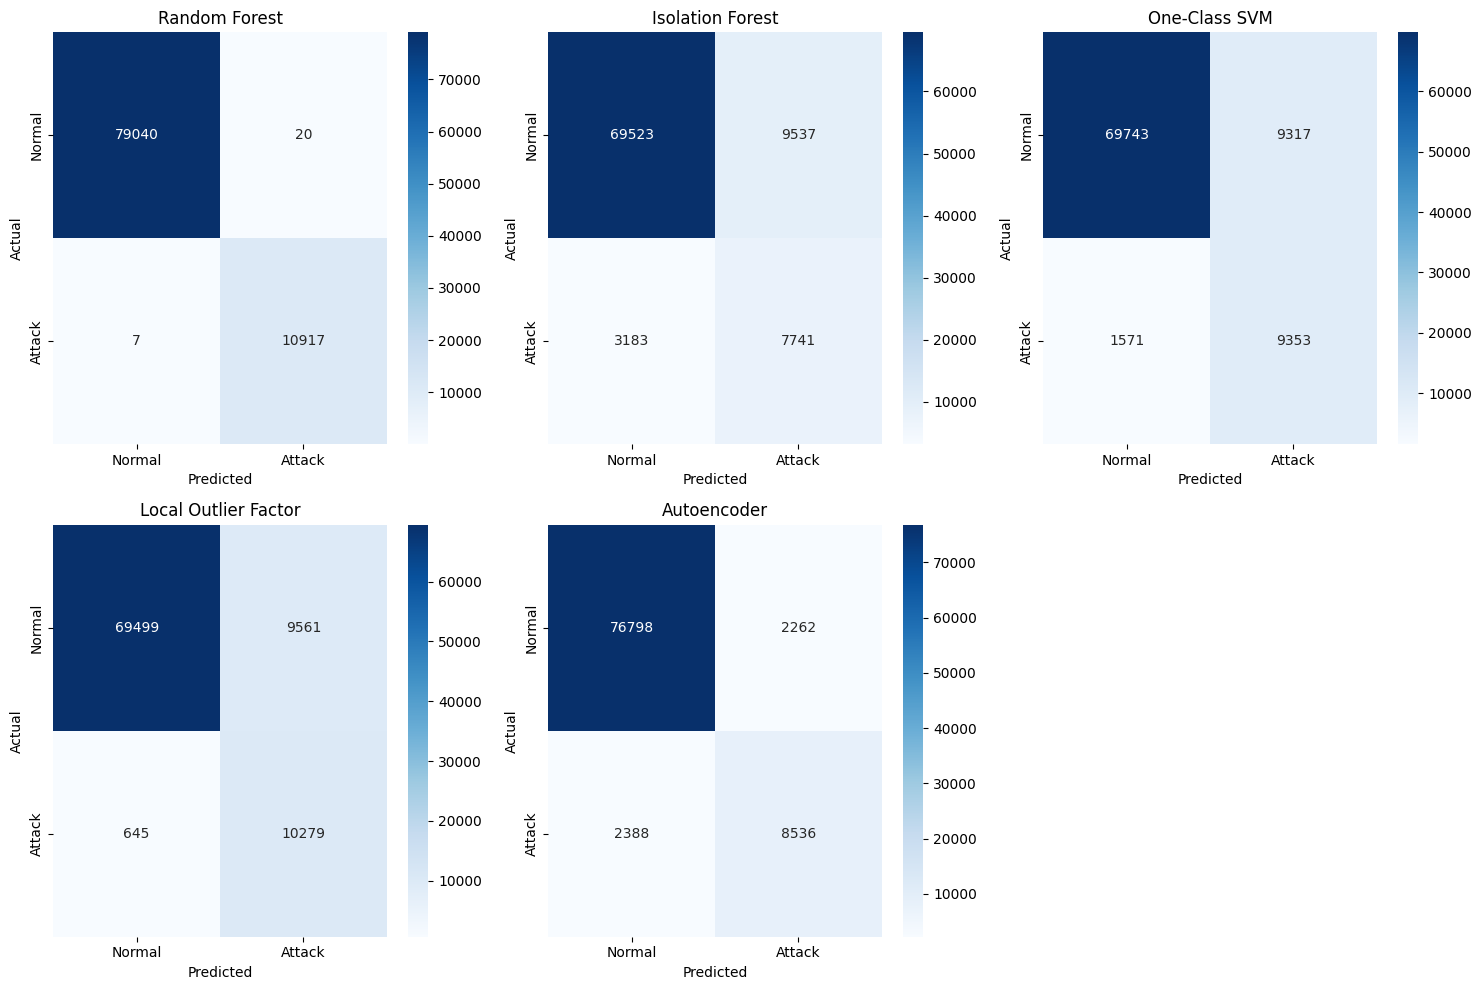

Saved: model_comparison_confusion.png


In [26]:
# Confusion matrices for all models
n_models = len(all_predictions)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(all_predictions.items()):
    if idx >= len(axes):
        break
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'],
                ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide unused subplots
for idx in range(len(all_predictions), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('model_comparison_confusion.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: model_comparison_confusion.png")

## Step 8: Summary and Recommendations

In [27]:
print("\n" + "="*80)
print("SUMMARY AND RECOMMENDATIONS FOR SCADA ANOMALY DETECTION")
print("="*80)

# Find best models by different criteria
best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
best_recall = results_df.loc[results_df['Recall'].idxmax()]
best_precision = results_df.loc[results_df['Precision'].idxmax()]
fastest_train = results_df.loc[results_df['Training Time (s)'].idxmin()]
fastest_inference = results_df.loc[results_df['Predictions/sec'].idxmax()]

print(f"\n📊 Best Overall (F1-Score): {best_f1['Model']} ({best_f1['F1-Score']:.4f})")
print(f"🎯 Best Detection Rate (Recall): {best_recall['Model']} ({best_recall['Recall']:.4f})")
print(f"✅ Lowest False Alarms (Precision): {best_precision['Model']} ({best_precision['Precision']:.4f})")
print(f"⚡ Fastest Training: {fastest_train['Model']} ({fastest_train['Training Time (s)']:.2f}s)")
print(f"🚀 Fastest Inference: {fastest_inference['Model']} ({fastest_inference['Predictions/sec']:,.0f} pred/sec)")

print("\n" + "-"*80)
print("RECOMMENDATIONS BY USE CASE:")
print("-"*80)

print("""
1. HIGH SECURITY (Cannot miss attacks):
   → Use model with highest RECALL
   → Accept more false positives for better detection

2. OPERATIONAL EFFICIENCY (Minimize false alarms):
   → Use model with highest PRECISION
   → Reduce alert fatigue for operators

3. BALANCED APPROACH:
   → Use model with highest F1-SCORE
   → Best trade-off between detection and false alarms

4. NO LABELED DATA AVAILABLE:
   → Use unsupervised methods (Isolation Forest, One-Class SVM, Autoencoder)
   → Train only on normal operation data

5. ZERO-DAY ATTACK DETECTION:
   → Use Isolation Forest or Autoencoder
   → Can detect novel attacks not seen in training

6. REAL-TIME REQUIREMENTS:
   → Check Predictions/sec metric
   → Random Forest and Isolation Forest typically fastest

7. HYBRID APPROACH (RECOMMENDED):
   → Isolation Forest for anomaly detection (first filter)
   → Random Forest for attack classification (if labels available)
""")


SUMMARY AND RECOMMENDATIONS FOR SCADA ANOMALY DETECTION

📊 Best Overall (F1-Score): Random Forest (0.9988)
🎯 Best Detection Rate (Recall): Random Forest (0.9994)
✅ Lowest False Alarms (Precision): Random Forest (0.9982)
⚡ Fastest Training: Isolation Forest (2.80s)
🚀 Fastest Inference: Isolation Forest (69,342 pred/sec)

--------------------------------------------------------------------------------
RECOMMENDATIONS BY USE CASE:
--------------------------------------------------------------------------------

1. HIGH SECURITY (Cannot miss attacks):
   → Use model with highest RECALL
   → Accept more false positives for better detection
   
2. OPERATIONAL EFFICIENCY (Minimize false alarms):
   → Use model with highest PRECISION
   → Reduce alert fatigue for operators
   
3. BALANCED APPROACH:
   → Use model with highest F1-SCORE
   → Best trade-off between detection and false alarms
   
4. NO LABELED DATA AVAILABLE:
   → Use unsupervised methods (Isolation Forest, One-Class SVM, Autoenc

In [28]:
# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✅ Results saved to: model_comparison_results.csv")

# Display final table
print("\n" + "="*80)
print("FINAL RESULTS TABLE")
print("="*80)
print(results_df.to_string(index=False))


✅ Results saved to: model_comparison_results.csv

FINAL RESULTS TABLE
               Model              Type  Accuracy  Precision   Recall  F1-Score  AUC-ROC  Training Time (s)  Inference Time (s)  Predictions/sec
       Random Forest        Supervised  0.999700   0.998171 0.999359  0.998765 0.999999          98.097270            1.327812     67768.629896
    Isolation Forest      Unsupervised  0.858642   0.448026 0.708623  0.548968 0.849907           2.804415            1.297683     69342.050408
       One-Class SVM      Unsupervised  0.879001   0.500964 0.856188  0.632088 0.914180          60.830407          106.455152       845.276140
Local Outlier Factor      Unsupervised  0.886580   0.518095 0.940956  0.668249 0.969093          22.532036           86.225935      1043.583929
         Autoencoder Unsupervised (DL)  0.948324   0.790517 0.781399  0.785931 0.938528         183.172636            3.850791     23367.666539
